# afocal window design notebook

This notebook implements window-design calculations for curved-wall vessels, as described in:
"...".

__Import statements:__ do not modify this cell

In [1]:
import windows
import utilities as util  # import print_md, plot_aberrations
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt

## Window design parameters

__Window types to design:__ set variables _True_ to perform design calculations or _False_ to skip calculation:

__Modify these parameters to match the application for which windows are to be designed:__

_General/universal parameters:_

In [2]:
inner_diameter = 11.53  # cm, inner diameter of curved-wall vessel
window_height = 8.0  # cm
design_wavelength = 532  # nm
window_material = 'fused silica'

windows.set_n_o(1.)  # refractive index of medium outside vessel
windows.set_n_i(1.)  # refractive index of medium within vessel

h_f = 1.0  # cm, size of inner retention flats

_Concentric window parameters:_

In [3]:
design_concentric = True

t_concentric = 2.5  # cm, thickness of the concentric window

_Afocal singlet window parameters:_

In [4]:
design_singlet = True

t_singlet = 2.5  # cm, thickness of the singlet window

_Cemented doublet window parameters:_

In [5]:
design_cemented_doublet = False

crown_material = 'bk7'

# guess values
Rm_cemented = inner_diameter * 2  # cm, guess for the middle surface radius of curvatue
Ro_cemented = inner_diameter * .6  # cm, guess for the outer surface radius of curvature
t_cemented_base = 1.8  # cm, thickness of the cemented window base (wetted side)
t_cemented_crown = 1.8  # cm, thickness of the cemented window crown (unwetted)
draw_guess = True

# optimization parameters
cemented_opt_params = {'Rm': True, 'Ro': True,
                       't_base': True, 't_crown': True}  # True to vary parameter, False to keep fixed
cemented_bounds = {'t_base': [1.5, 4],
                   't_crown': [1., 4]}  # bounds on the thicknesses of the elements; radii bounds set automatically

_Air-spaced doublet window parameters:_

In [6]:
design_airspace_doublet = True

lens_material = 'bk7'

# guess values
t_airspace_window = 1.5  # cm, thickness of the cemented window base (wetted side)
x_airspace = 2
Ri_airspace_lens = 1.1 * inner_diameter
Ro_airspace_lens = 0.9 * inner_diameter
t_airspace_lens = 0.8  # cm, thickness of the cemented window crown (unwetted)
h_airspace_lens = 1.2 * window_height

draw_guess = True

# optimization parameters
cemented_opt_params = {'Rm': True, 'Ro': True,
                       't_base': True, 't_crown': True}  # True to vary parameter, False to keep fixed
cemented_bounds = {'t_base': [1.5, 4],
                   't_crown': [1., 4]}  # bounds on the thicknesses of the elements; radii bounds set automatically

# Concentric/Annular window design

Concentric windows consist of a section of an annulus; concentric windows are inherently _not_ afocal.

__Concentric Window as Specified__

Ri =	 5.765 cm
Ro =	 8.265 cm
t =	 2.500 cm
power =	-1.655 1/m


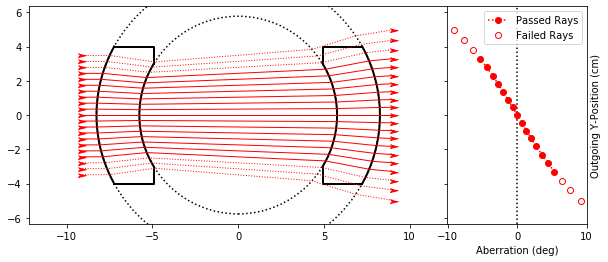

__Concentric Window Aberration vs. Thickness__

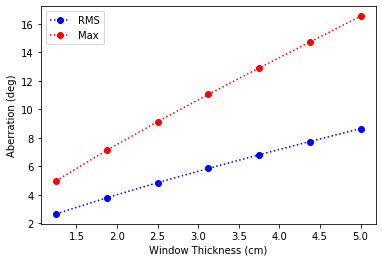

In [7]:
if design_concentric:
    # define concentric window geometry
    Ri = inner_diameter / 2
    Ro = Ri + t_concentric
    h = window_height
    t = t_concentric

    # draw and ray trace the window
    util.print_md('__Concentric Window as Specified__')
    concentric = windows.Concentric(Ri, h, t, h_f, material=window_material, design_wavelength=design_wavelength,
                                    draw=False, trace=True, draw_rays=False)
    
    concentric.print_dims()

    fig, axs = util.ray_aberration_subplots()
    plt.sca(axs[0])
    concentric.draw_annulus(ls=':')
    concentric.draw(new_figure=False)
    plt.ylim(concentric.Ri * np.array([-1.1, 1.1]))
    concentric.draw_rays(sets='success')
    concentric.draw_rays(sets='failed', ls=':')

    plt.sca(axs[1])
    axs[1].yaxis.set_label_position("right")
    util.plot_aberrations(concentric, unit='deg', c='r', new_fig=False,
                          yloc='out', flip_axes=True)
    plt.show()


    util.print_md('__Concentric Window Aberration vs. Thickness__')
    ts = np.linspace(t / 2, 2 * t, 7)
    abb_rms = np.zeros_like(ts)
    abb_max = np.zeros_like(ts)

    for i, t in enumerate(ts):
        draw = False
        concentric._t_1 = t
        concentric.trace_ray_set(n_rays=31, draw=False, inplace=True)
        abb_rms[i] = concentric.rays.rms_aberration(sets='all', unit='deg')
        abb_max[i] = concentric.rays.max_aberration(sets='all', unit='deg')

    plt.figure()
    plt.plot(ts, abb_rms, ':ob', label='RMS')
    plt.plot(ts, abb_max, ':or', label='Max')
    plt.xlabel('Window Thickness (cm)')
    plt.ylabel('Aberration (deg)')
    plt.legend()

# Afocal singlet window design

__Optimization Criteria:__ 'analytical'

Ri =	 5.765 cm
Ro =	 6.396 cm
t =	 2.000 cm
power =	-0.000 1/m


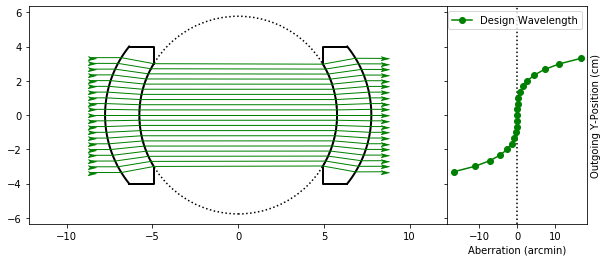

__Optimization Criteria:__ 'rms_aberration'

Ri =	 5.765 cm
Ro =	 6.428 cm
t =	 2.000 cm
power =	-0.039 1/m


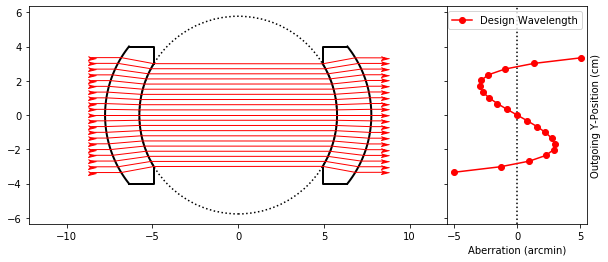

__Optimization Criteria:__ 'max_aberration'

Ri =	 5.765 cm
Ro =	 6.432 cm
t =	 2.000 cm
power =	-0.044 1/m


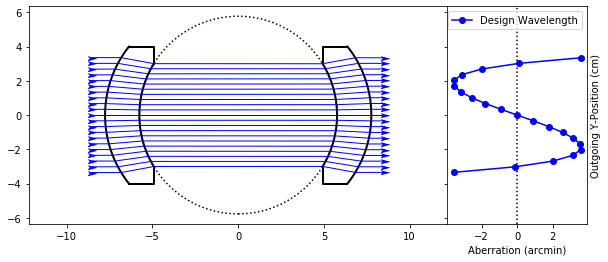

__Comparison of Aberrations by Design Criteria__

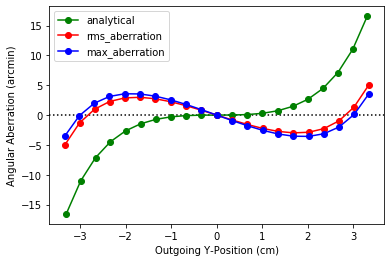

__Afocal Singlet Window Aberration vs. Thickness__

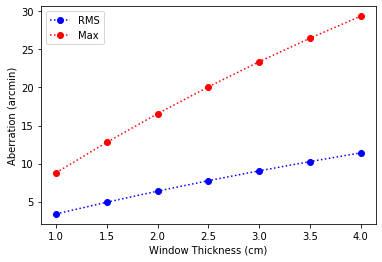

__Chromatic Aberrations__

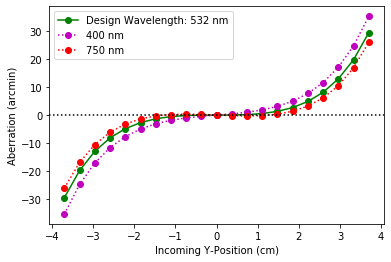

In [8]:
if design_singlet:
    # define singlet window geometry
    Ri = inner_diameter / 2
    h = window_height
    t = 2.0  # t_singlet

    show_chromatic_aberration = False

    singlet = windows.ZeroPowerSinglet(Ri, h, t, h_f=h_f, material=window_material,
                                       design_wavelength=design_wavelength, draw=False,
                                       trace=True, draw_rays=False)

    methods, cs, hs = ['analytical', 'rms_aberration', 'max_aberration'], ['g', 'r', 'b'], []
    for Ro_method, c in zip(methods, cs):

        singlet.optimize_Ro(Ro_method, inplace=True)

        util.print_md(f"__Optimization Criteria:__ '{Ro_method}'")
        singlet.print_dims()
        
        fig, axs = util.ray_aberration_subplots()

        # draw and ray trace the window
        plt.sca(axs[0])
        singlet.draw(center_circle=True, new_figure=False)
        singlet.draw_rays(c=c)

        plt.sca(axs[1])
        # plt.axhline(ls=':', c='k')
        util.plot_aberrations(singlet, unit='arcmin', c=c, new_fig=False, ls='-', yloc='out', flip_axes=True,
                              failed=False, prefix='Design Wavelength')
        hs += plt.gca().lines[-1:]
        if show_chromatic_aberration:
            util.plot_aberrations(singlet.trace_ray_set(wavelength=400, draw=False), yloc='out', flip_axes=True,
                                  failed=False, new_fig=False, unit='arcmin', c='y', mfc='none', ls='', prefix='400 nm')
            util.plot_aberrations(singlet.trace_ray_set(wavelength=750, draw=False), yloc='out', flip_axes=True,
                                  failed=False, new_fig=False, unit='arcmin', c='m', mfc='none', ls='', prefix='750 nm')

        plt.show()

    # ###############################################################
    util.print_md(f'__Comparison of Aberrations by Design Criteria__')

    plt.figure()
    ax = plt.gcf().add_subplot(111)
    ax.axhline(0, c='k', ls=':')
    for label, h, c in zip(methods, hs, cs):
        plt.plot(*h.get_data()[::-1], '-o', c=c, label=label)
    plt.legend()
    plt.ylabel(f'Angular Aberration (arcmin)')
    plt.xlabel('Outgoing Y-Position (cm)')
    plt.show()
    
    # ###############################################################
    util.print_md('__Afocal Singlet Window Aberration vs. Thickness__')
    
    Ro_method = 'analytical'
    ts = np.linspace(t / 2, 2 * t, 7)
    abb_rms = np.zeros_like(ts)
    abb_max = np.zeros_like(ts)

    for i, t in enumerate(ts):
        draw = False
        singlet._t_1 = t
        singlet.optimize_Ro(Ro_method, inplace=True)
        singlet.trace_ray_set(n_rays=31, draw=False, inplace=True)
        abb_rms[i] = singlet.rays.rms_aberration(sets='all', unit='arcmin')
        abb_max[i] = singlet.rays.max_aberration(sets='all', unit='arcmin')

    plt.figure()
    plt.plot(ts, abb_rms, ':ob', label='RMS')
    plt.plot(ts, abb_max, ':or', label='Max')
    plt.xlabel('Window Thickness (cm)')
    plt.ylabel('Aberration (arcmin)')
    plt.legend()
    plt.show()
    
    # ###############################################################
    util.print_md(f'__Chromatic Aberrations__')

    Ro_method = 'analytical'
    singlet.optimize_Ro(Ro_method, inplace=True)

    util.plot_aberrations(singlet, unit='arcmin', c='g', new_fig=True,
                          ls='-', failed=False, prefix=f'Design Wavelength: {singlet.design_wavelength:3.0f} nm')
    util.plot_aberrations(singlet.trace_ray_set(wavelength=400, draw=False),
                          failed=False, new_fig=False,
                          unit='arcmin', c='m', prefix='400 nm')
    util.plot_aberrations(singlet.trace_ray_set(wavelength=750, draw=False),
                          failed=False, new_fig=False,
                          unit='arcmin', c='r', prefix='750 nm')
    plt.axhline(0, c='k', ls=':')


### Trying to think if there is a better way to optimize a singlet

In [9]:
# singlet2 = singlet.inplace(False)
# print(singlet2.power)

# # Ro fixed
# t0 = 2.
# singlet2._t_1 = t0
# singlet2.optimize_Ro('analytical', inplace=True)
# util.plot_aberrations(singlet2, unit='arcmin', c='k', new_fig=False,
#                       ls='-', failed=False, prefix=f'{t0:3.1f} cm ' +
#                       f'Analytical')

# for t in np.linspace(1.5, 2.5, 10):
#     singlet2._t_1 = t
#     singlet2.trace_ray_set(draw=False, inplace=True)
#     P = singlet2.power
#     util.plot_aberrations(singlet2, unit='arcmin', c=None, new_fig=False,
#                           ls='-', failed=False, prefix=f'{t:3.1f} cm ' +
#                           f'(P={P:4.3e}) cm$^{{{-1}}}$')
#     plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left')
#     plt.title(f'Changing Thickness with R$_o$ Fixed')

    
# # optical power fixed
# singlet2._t_1 = t0
# singlet2.optimize_Ro('analytical', inplace=True)
# P0 = singlet2.power
# util.plot_aberrations(singlet2, unit='arcmin', c='k', new_fig=True,
#                       ls='-', failed=False, prefix=f'{t0:3.1f} cm ' +
#                       f'Analytical')

# for t in np.linspace(1.5, 2.5, 10):
#     singlet2._t_1 = t
#     singlet2.set_Ro_by_power(P0)
#     singlet2.trace_ray_set(draw=False, inplace=True)
#     P = singlet2.power
#     util.plot_aberrations(singlet2, unit='arcmin', c=None, new_fig=False,
#                           ls='-', failed=False, prefix=f'{t:3.1f} cm ' +
#                           f'(P={P:4.3e}) cm$^{{{-1}}}$')
#     plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left')
#     plt.title(f'Changing Thickness with R$_o$ Fixed')

In [10]:
# raise Exception

# Cemented doublet window design

23.06


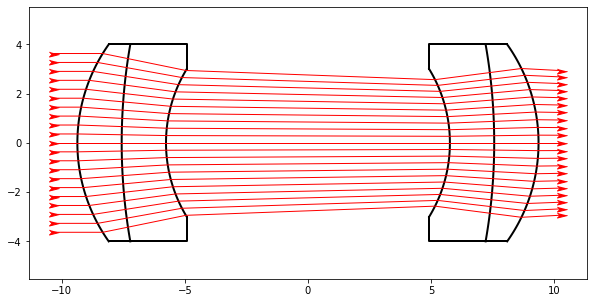

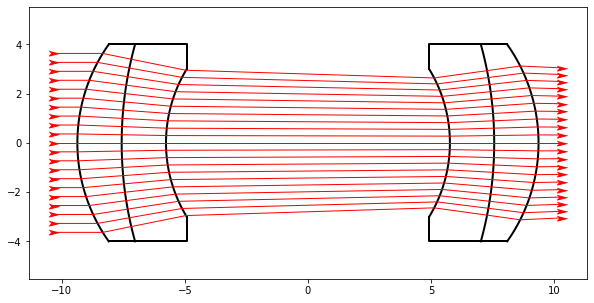

In [11]:
# define cemented doublet window geometry
Ri = inner_diameter / 2
h = window_height

# guess values
Rm, Ro = Rm_cemented, Ro_cemented
t1, t2 = t_cemented_base, t_cemented_crown

doublet = windows.CementedDoublet(Ri=Ri, Rm=Rm, Ro=Ro, h=h, t1=t1, t2=t2, h_f=h_f,
                                  wetted_material=window_material, crown_material=crown_material,
                                  draw=True, trace=True, draw_rays=True)
print(Rm)
doublet.set_parameter('Rm', 15)

doublet.draw()
doublet.trace_ray_set()

In [12]:
if design_cemented_doublet:
    
    show_chromatic_aberration = False
    
    # define cemented doublet window geometry
    Ri = inner_diameter / 2
    h = window_height
    
    # guess values
    Rm, Ro = Rm_cemented, Ro_cemented
    t1, t2 = t_cemented_base, t_cemented_crown
    
    # optimization options
    bounds = {'t1': cemented_bounds.get('t_base', [None, None]),
              't2': cemented_bounds.get('t_crown', [None, None])}
#     which_params = [cemented_opt_params.get(p, True) for p in windows.CementedDoublet.opt_params]
#     bounds = [cemented_bounds.get(p, [None, None]) for p in windows.CementedDoublet.opt_params]

    doublet = windows.CementedDoublet(Ri=Ri, Rm=Rm, Ro=Ro, h=h, t1=t1, t2=t2, h_f=h_f,
                                      wetted_material=window_material, crown_material=crown_material,
                                      draw=False, trace=True, draw_rays=False)
    if draw_guess:
        util.print_md(f"__Initial (Guess) Parameters__")
        doublet.print_dims()
                
        fig, axs = util.ray_aberration_subplots()

        # draw and ray trace the window
        plt.sca(axs[0])
        doublet.draw(center_circle=True, new_figure=False)
        doublet.draw_rays(c='g')
        
        plt.sca(axs[1])
        util.plot_aberrations(doublet, unit='arcmin', c='g', new_fig=False, ls='-', yloc='out', flip_axes=True,
                              failed=False, prefix='Design Wavelength')
        plt.show()
        
    
    methods, cs, hs = ['rms_aberration', 'max_aberration'], ['r', 'b'], []
    for opt_method, c in zip(methods, cs):
        
        doublet.optimize_window(opt_method)  #, n_rays=51, y_range=np.array([-3.5, 3.5]))
        
        util.print_md(f"__Optimization Criteria:__ '{opt_method}'")
        doublet.print_dims()
        
        fig, axs = util.ray_aberration_subplots()

        # draw and ray trace the window
        plt.sca(axs[0])
        doublet.draw(center_circle=True, new_figure=False)
        doublet.draw_rays(c=c)

        plt.sca(axs[1])
        # plt.axhline(ls=':', c='k')
        util.plot_aberrations(doublet, unit='arcmin', c=c, new_fig=False, ls='-', yloc='out', flip_axes=True,
                              failed=False, prefix='Design Wavelength')
        
        
        hs += plt.gca().lines[-1:]
        if show_chromatic_aberration:
            util.plot_aberrations(doublet.trace_ray_set(wavelength=400, draw=False), yloc='out', flip_axes=True,
                                  failed=False, new_fig=False, unit='arcmin', c='y', mfc='none', ls='', prefix='400 nm')
            util.plot_aberrations(doublet.trace_ray_set(wavelength=750, draw=False), yloc='out', flip_axes=True,
                                  failed=False, new_fig=False, unit='arcmin', c='m', mfc='none', ls='', prefix='750 nm')

        plt.show()

In [13]:
print(doublet.optimization_parameters)
all([p in doublet.all_optimization_parameters for p in 
     doublet.default_optimization_parameters])

('t_1', 't_2', 'power_1', 'power_2')


True

In [14]:
P1, P2 = doublet.power_1, doublet.power_2
n1, n2 = doublet.n_1, doublet.n_2
t1, t2 = doublet.t_1, doublet.t_2

print(P1, n1, t1)
print(P2, n2, t2)

print(P1 + P2 + (t1 + t2)/(n1) * P1**2)
print(P1 + P2 + (t1 + t2)/(n2) * P2**2)
print(P1 + P2 + (t1 + t2)*2/(n1+n2) * P1**2)

-8.42289691689467 1.460764 1.8
7.153026092924879 1.519544 1.8
173.57198788933465
119.948610661154
170.12361797080004


In [15]:
Rm0, Ro0, t10, t20 = doublet.Rm, doublet.Ro, doublet.t_1, doublet.t_2
Rm0, Ro0, t10, t20

def reset_doublet():
    doublet._Rm = Rm0
    doublet._Ro = Ro0
    doublet._t_1 = t10
    doublet._t_2 = t20


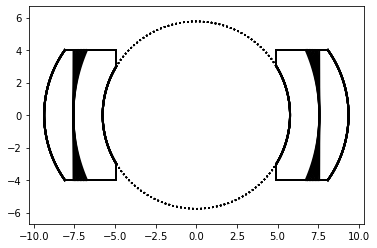

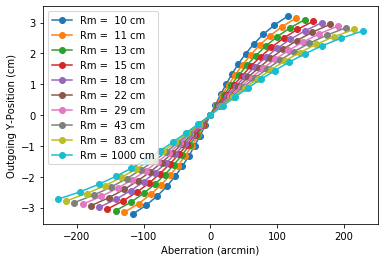

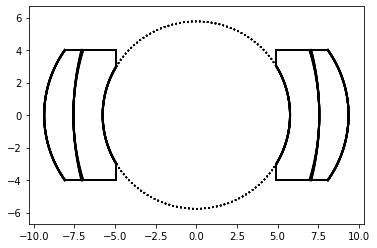

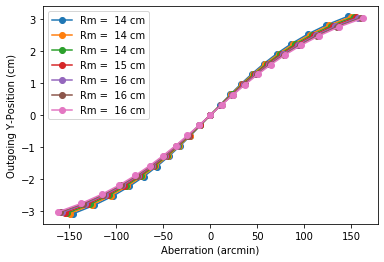

In [16]:
# fig, axs = util.ray_aberration_subplots()
def make_axes():
    axs = []
    for i in range(2):
        plt.figure()
        axs += [plt.gca()]
    return axs

axs = make_axes()
    
for K in np.linspace(.1, .001, 10):
    doublet._Rm = 1 / K
    Rm = doublet.Rm
    doublet.trace_ray_set(draw=False)
    
    # draw and ray trace the window
    plt.sca(axs[0])
    doublet.draw(center_circle=True, new_figure=False)
#     doublet.draw_rays(c='g')

    plt.sca(axs[1])
    util.plot_aberrations(doublet, unit='arcmin', c=None, new_fig=False, ls='-', yloc='out', flip_axes=True,
                          failed=False, prefix=f'Rm = {Rm:3.0f} cm')

axs = make_axes()
for Rm in np.linspace(.9 * Rm0, 1.1 * Rm0, 7):
    doublet._Rm = Rm
    doublet.trace_ray_set(draw=False)
    
    # draw and ray trace the window
    plt.sca(axs[0])
    doublet.draw(center_circle=True, new_figure=False)
#     doublet.draw_rays(c='g')

    plt.sca(axs[1])
    util.plot_aberrations(doublet, unit='arcmin', c=None, new_fig=False, ls='-', yloc='out', flip_axes=True,
                          failed=False, prefix=f'Rm = {Rm:3.0f} cm')
    
reset_doublet()

# Air-spaced doublet window design

__Initial (Guess) Parameters__

_Concentric Window:_

   Ri =	 5.765 cm
   Ro =	 7.265 cm
   t =	 1.500 cm
   power =	-1.130 1/m


_Bispherical Lens:_

   Ri =	12.683 cm
   Ro =	10.377 cm
   t =	 0.800 cm
   power =	0.896 1/m

x_airgap =	 2.000 cm


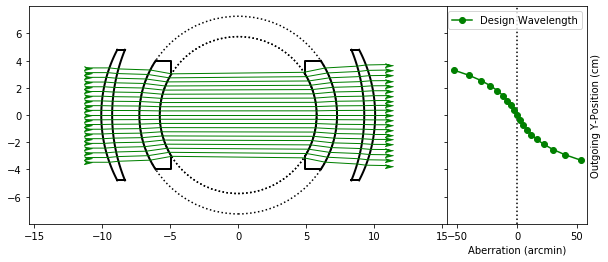

In [26]:
# define air-spaced doublet window
Ri_w = inner_diameter / 2
h_w = window_height
t_w = t_airspace_window

annulus = windows.Concentric(Ri_w, h_w, t_w, h_f=h_f, material=window_material)

# define air-spaced doublet lens guess
xi_l = annulus.x_max + x_airspace
Ri_l = Ri_airspace_lens
Ro_l = Ro_airspace_lens
t_l = t_airspace_lens
h_l = h_airspace_lens

lens = windows.BisphericalLens(Ri_l, Ro_l, h_l, t_l, xi_l, h_f=0.)

# construct the doublet object
airdoublet = windows.AirspaceDoublet(annulus, lens)
airdoublet.trace_ray_set(draw=False)

if draw_guess:

    fig, axs = util.ray_aberration_subplots()

    util.print_md(f"__Initial (Guess) Parameters__")
    airdoublet.print_dims('   ')

    # draw and ray trace the window
    plt.sca(axs[0])
    airdoublet.draw(center_circle=True, new_figure=False)
    airdoublet.draw_rays(c='g')

    plt.sca(axs[1])
    util.plot_aberrations(airdoublet, unit='arcmin', c='g', new_fig=False, ls='-', yloc='out', flip_axes=True,
                          failed=False, prefix='Design Wavelength')
    plt.show()


__Optimized__

_Concentric Window:_

   Ri =	 5.765 cm
   Ro =	 7.265 cm
   t =	 1.500 cm
   power =	-1.130 1/m


_Bispherical Lens:_

   Ri =	12.683 cm
   Ro =	10.263 cm
   t =	 1.500 cm
   power =	1.024 1/m

x_airgap =	 5.000 cm


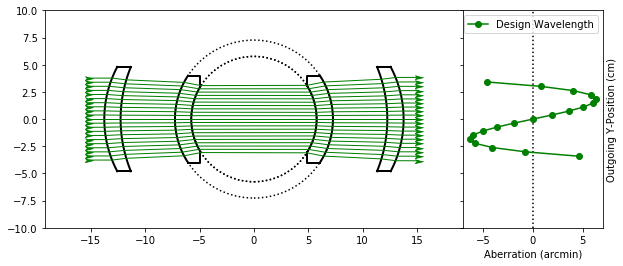

In [28]:
# airdoublet.set_parameters(('t_lens', 't_window', 'x_air'), (1, 2, 5))

opt_params = ('t_lens', 'Ri_lens', 'power_lens', 'x_air')
bounds = {'t_lens': (0.5, 1.5),
          'x_air': (0.1, 5)}

airdoublet.optimize_window(parameters=opt_params,
                           bounds_dict=bounds)  #, 
#                            y_range=(-5, 5))

if True:
    util.print_md(f"__Optimized__")
    airdoublet.print_dims('   ')
    fig, axs = util.ray_aberration_subplots()

    # draw and ray trace the window
    plt.sca(axs[0])
    airdoublet.draw(center_circle=True, new_figure=False)
    airdoublet.draw_rays(c='g')

    plt.sca(axs[1])
    util.plot_aberrations(airdoublet, unit='arcmin', c='g', new_fig=False, ls='-', yloc='out', flip_axes=True,
                          failed=False, prefix='Design Wavelength')
    
#     axs[0].set_xlim((airdoublet.default_x_start * 1.5,
#                      airdoublet.default_x_stop * 1.5))
    axs[0].set_ylim((-10, 10))
    
    plt.show()

__Optimized__

_Concentric Window:_

   Ri =	 5.765 cm
   Ro =	 7.265 cm
   t =	 1.500 cm
   power =	-1.130 1/m


_Bispherical Lens:_

   Ri =	12.683 cm
   Ro =	10.263 cm
   t =	 1.500 cm
   power =	1.024 1/m

x_airgap =	 5.000 cm


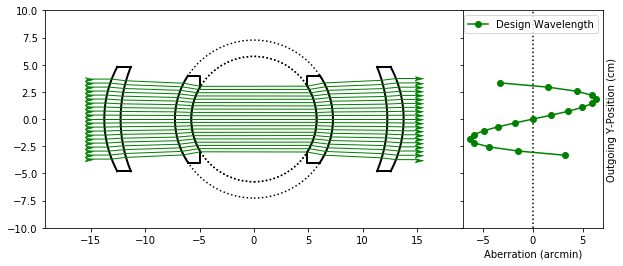

In [31]:
opt_params = ('Ri_lens',)
bounds = {'t_lens': (0.5, 1.5),
          'x_air': (0.1, 5)}

airdoublet.optimize_window(parameters=opt_params,
                           bounds_dict=bounds)  #, 
#                            y_range=(-5, 5))

if True:
    util.print_md(f"__Optimized__")
    airdoublet.print_dims('   ')
    fig, axs = util.ray_aberration_subplots()

    # draw and ray trace the window
    plt.sca(axs[0])
    airdoublet.draw(center_circle=True, new_figure=False)
    airdoublet.draw_rays(c='g')

    plt.sca(axs[1])
    util.plot_aberrations(airdoublet, unit='arcmin', c='g', new_fig=False, ls='-', yloc='out', flip_axes=True,
                          failed=False, prefix='Design Wavelength')
    
#     axs[0].set_xlim((airdoublet.default_x_start * 1.5,
#                      airdoublet.default_x_stop * 1.5))
    axs[0].set_ylim((-10, 10))
    
    plt.show()

In [ ]:
airdoublet.draw()
airdoublet.trace_ray_set(y_range=(-5, 5))
# airdoublet.rays.draw(marker='.')
airdoublet.estimated_Y_max_in

airdoublet.default_x_start